# Unsupervised Learning for Single-Cell RNA-Sequencing Data

## Tutorial Overview

This tutorial demonstrates unsupervised learning techniques applied to single-cell RNA-sequencing (scRNA-seq) data. We will explore:

1. **Data Loading and Visualization**: Understanding single-cell RNA-seq data structure
2. **Dimensionality Reduction**: PCA, UMAP, and t-SNE for visualization
3. **Clustering**: K-means clustering to identify cell types
4. **Advanced Methods**: Variational Autoencoders (VAE) and Louvain graph-based clustering

---

## Background: Single-Cell RNA-Sequencing

Single-cell RNA-sequencing (scRNA-seq) is a powerful technology that measures gene expression at the individual cell level. Unlike bulk RNA-seq which measures average expression across thousands of cells, scRNA-seq allows us to:

- **Identify cell types** based on gene expression patterns
- **Discover cellular heterogeneity** within tissues
- **Track developmental trajectories** and cell state transitions
- **Understand disease mechanisms** at cellular resolution

### Key Challenges:
- **High dimensionality**: Thousands of genes (features) per cell
- **Sparsity**: Many genes have zero or very low expression
- **Noise**: Technical and biological variability
- **Large scale**: Modern datasets contain 10,000+ cells

### Data Structure:
- **Rows**: Individual cells
- **Columns**: Genes (features)
- **Values**: Gene expression counts (typically log-normalized)

## 1. Data Loading and Initial Exploration

Let's start by loading the single-cell RNA-seq data and exploring its structure.

In [177]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import silhouette_score, adjusted_rand_score
import warnings
warnings.filterwarnings('ignore')

# Import scanpy for loading single-cell datasets
try:
    import scanpy as sc
    print("scanpy imported successfully!")
except ImportError:
    print("Warning: scanpy not installed. Install with: pip install scanpy")

# Set plotting style
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

scanpy imported successfully!
Libraries imported successfully!


In [178]:
# Load single-cell RNA-seq data using scanpy
# Using pbmc3k_processed dataset (already preprocessed with cell type labels!)
import scanpy as sc

print("Loading pbmc3k_processed dataset using scanpy...")
print("(This will download the dataset automatically on first use)")

# Load the pbmc3k_processed dataset
# This dataset has been preprocessed and includes cell type labels
adata = sc.datasets.pbmc3k_processed()

print(f"\nDataset loaded successfully!")
print(f"Shape: {adata.shape} (cells x genes)")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Extract expression matrix (already preprocessed - normalized and log-transformed)
# adata.X contains the preprocessed expression matrix (sparse matrix)
expression_matrix = adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X

# Get gene names (features)
gene_names = adata.var_names.tolist()

# Get cell names
cell_names = adata.obs_names.tolist()

# Create DataFrame for compatibility with rest of notebook
data = pd.DataFrame(expression_matrix, columns=gene_names, index=cell_names)

# Extract cell type annotations
# pbmc3k_processed has cell type labels in 'louvain' column
true_cell_types = None
if 'louvain' in adata.obs.columns:
    true_cell_types = adata.obs['louvain'].values
    print(f"\n✓ Cell type annotations found in 'louvain'!")
    print(f"Cell types: {np.unique(true_cell_types, return_counts=True)}")
    print(f"\nCell type breakdown:")
    for cell_type, count in zip(*np.unique(true_cell_types, return_counts=True)):
        print(f"  {cell_type}: {count} cells")
else:
    print(f"\n✗ No cell type annotations found.")
    print(f"Available obs columns: {list(adata.obs.columns)}")

# Use preprocessed data directly (no need for additional preprocessing)
# The data is already normalized, log-transformed, and highly variable genes are selected
X = expression_matrix  # Use directly for downstream analysis

print(f"\nFirst few rows and columns:")
print(data.iloc[:5, :5])
print(f"\nData summary:")
print(f"  Min expression: {data.values.min():.2f}")
print(f"  Max expression: {data.values.max():.2f}")
print(f"  Mean expression: {data.values.mean():.2f}")
print(f"  Sparsity: {(data.values == 0).sum() / data.size * 100:.2f}%")
print(f"\nNote: Data is already preprocessed (normalized, log-transformed, highly variable genes selected)")

Loading pbmc3k_processed dataset using scanpy...
(This will download the dataset automatically on first use)

Dataset loaded successfully!
Shape: (2638, 1838) (cells x genes)
Number of cells: 2638
Number of genes: 1838

✓ Cell type annotations found in 'louvain'!
Cell types: (array(['B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD8 T cells',
       'Dendritic cells', 'FCGR3A+ Monocytes', 'Megakaryocytes',
       'NK cells'], dtype=object), array([ 342,  480, 1144,  316,   37,  150,   15,  154]))

Cell type breakdown:
  B cells: 342 cells
  CD14+ Monocytes: 480 cells
  CD4 T cells: 1144 cells
  CD8 T cells: 316 cells
  Dendritic cells: 37 cells
  FCGR3A+ Monocytes: 150 cells
  Megakaryocytes: 15 cells
  NK cells: 154 cells

First few rows and columns:
                   TNFRSF4    CPSF3L    ATAD3C   C1orf86      RER1
AAACATACAACCAC-1 -0.171470 -0.280812 -0.046677 -0.475169 -0.544024
AAACATTGAGCTAC-1 -0.214582 -0.372653 -0.054804 -0.683391  0.633951
AAACATTGATCAGC-1 -0.376887 -0.295084 -

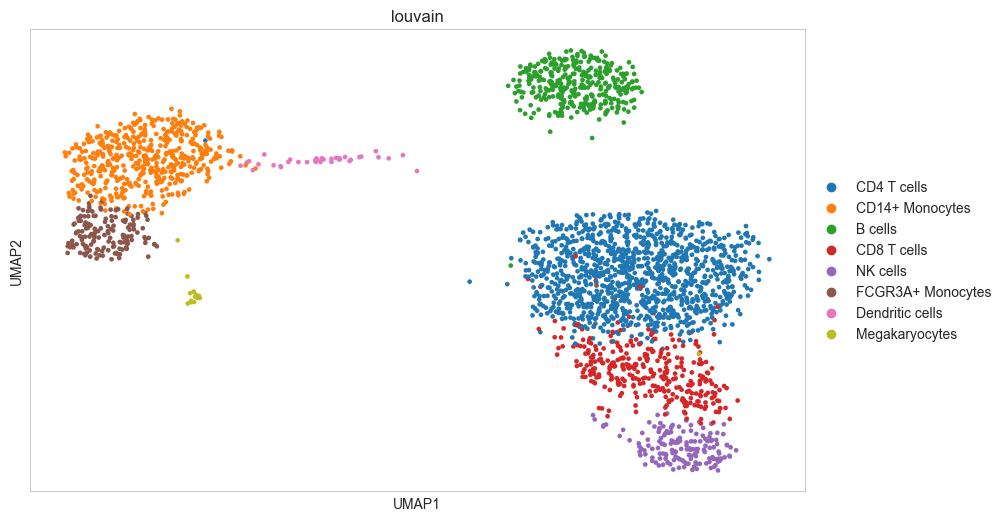

In [179]:
# Plot UMAP using scanpy (requires UMAP in adata.obsm)
if 'adata' in locals() and 'X_umap' in adata.obsm:
    sc.pl.umap(adata, color='louvain' if 'louvain' in adata.obs.columns else None)
else:
    print("Note: UMAP not available in adata.obsm. Use the manual UMAP visualization above.")

## 2. Data Visualization using UMAP and t-SNE

UMAP (Uniform Manifold Approximation and Projection) and t-SNE (t-distributed Stochastic Neighbor Embedding) are powerful techniques for visualizing high-dimensional data in 2D or 3D space.

### UMAP vs t-SNE:
- **t-SNE**: Better at preserving local structure, but slower and can't handle new data points
- **UMAP**: Faster, preserves both local and global structure, can transform new data

### Important: Matching scanpy's UMAP Implementation

To get results similar to `sc.pl.umap(adata, color='louvain')`, we need to:

1. **Use PCA space instead of raw expression**: Scanpy computes UMAP on the PCA-reduced space (typically first 50 PCs), not on the raw scaled expression matrix. This:
   - Reduces noise
   - Focuses on the most informative dimensions
   - Improves separation between cell types

2. **Use appropriate `min_dist` parameter**:
   - **min_dist=0.1**: Creates tight clusters (cells are very close together)
   - **min_dist=0.5** (scanpy default): Creates better separation between clusters
   - Higher values (0.5-1.0) give more space between clusters, making cell types more distinct

3. **Use same `n_neighbors`**: Both use 15 neighbors (default)

**Key Takeaway**: The input space (PCA vs raw) and `min_dist` parameter significantly affect cluster separation in UMAP visualizations.

In [180]:
# Install umap-learn if not already installed
# !pip install umap-learn

try:
    import umap
    print("UMAP library imported successfully!")
except ImportError:
    print("UMAP not installed. Please install with: pip install umap-learn")
    print("Continuing with t-SNE only...")

UMAP library imported successfully!


In [181]:
# Standardize the data for better visualization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Scaled data mean: {X_scaled.mean():.4f}, std: {X_scaled.std():.4f}")

Scaled data shape: (2638, 1838)
Scaled data mean: -0.0000, std: 1.0000


Running UMAP...
Note: Using PCA space (like scanpy) instead of raw scaled data
      This typically gives better separation of cell types
UMAP stored in adata.obsm['X_umap']
UMAP embedding shape: (2638, 2)
Used 50 principal components for UMAP


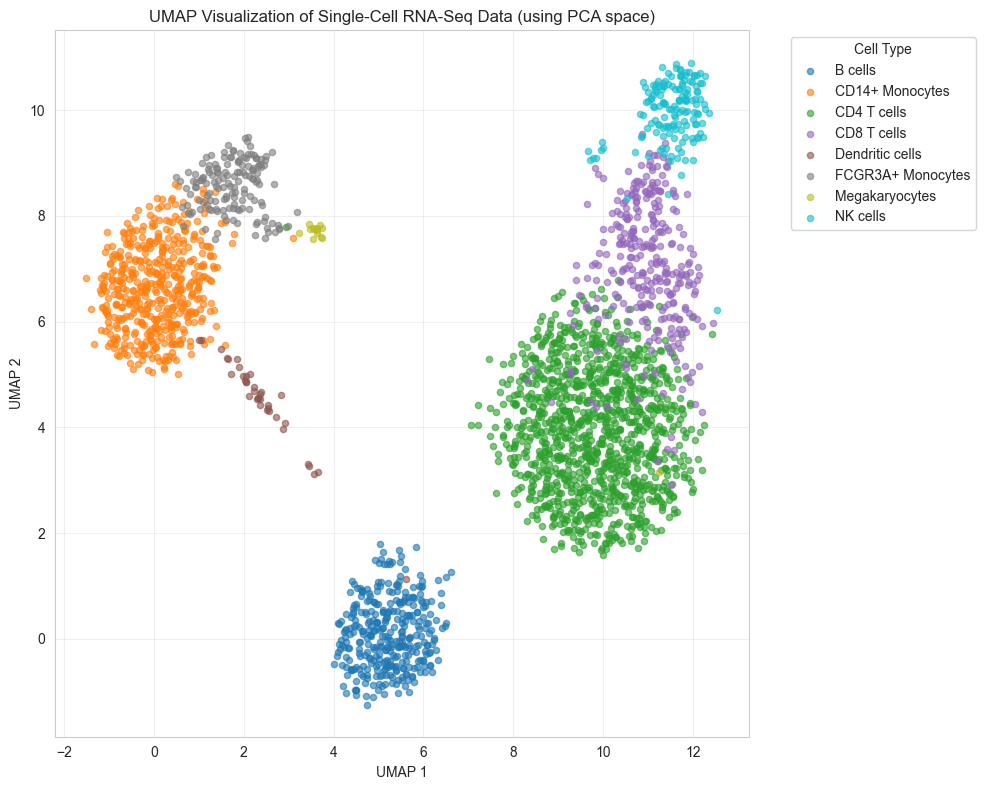

In [ ]:
# UMAP visualization
# Using PCA space (like scanpy) for better results

if 'X_umap' not in locals():
    try:
        import umap

        print("Running UMAP...")
        print("Note: Using PCA space (like scanpy) instead of raw scaled data")
        print("      This typically gives better separation of cell types")

        # Use PCA space for UMAP (like scanpy does)
        # First ensure we have PCA
        if 'X_pca' not in locals():
            print("Computing PCA first...")
            pca = PCA(n_components=50)
            X_pca = pca.fit_transform(X_scaled)

        # Use first 50 PCs for UMAP (scanpy's default approach)
        n_pcs = min(50, X_pca.shape[1])
        X_for_umap = X_pca[:, :n_pcs]

        # Use scanpy's default UMAP parameters for better separation
        # min_dist=0.5 (not 0.1) gives better separation between clusters
        reducer_umap = umap.UMAP(
            n_components=2,
            random_state=42,
            n_neighbors=15,  # Same as scanpy
            min_dist=0.5,    # Scanpy default (was 0.1 - too tight)
            metric='euclidean'
        )
        X_umap = reducer_umap.fit_transform(X_for_umap)

        # Store UMAP in adata for scanpy plotting functions
        if 'adata' in locals():
            adata.obsm['X_umap'] = X_umap
            print("UMAP stored in adata.obsm['X_umap']")

        print(f"UMAP embedding shape: {X_umap.shape}")
        print(f"Used {n_pcs} principal components for UMAP")

    except ImportError:
        print("UMAP not available, skipping...")
        X_umap = None

# Plot UMAP if available
if 'X_umap' in locals() and X_umap is not None:
    plt.figure(figsize=(10, 8))

    # Use louvain labels from adata if available
    if 'adata' in locals() and 'louvain' in adata.obs.columns:
        cell_labels = adata.obs['louvain'].values
        unique_types = np.unique(cell_labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))

        for k, cell_type in enumerate(unique_types):
            mask = cell_labels == cell_type
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1],
                       c=[colors[k]], label=cell_type, alpha=0.6, s=20)

        plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    elif 'true_cell_types' in locals() and true_cell_types is not None:
        # Fallback to true_cell_types if available
        unique_types = np.unique(true_cell_types)
        colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))

        for k, cell_type in enumerate(unique_types):
            mask = true_cell_types == cell_type
            plt.scatter(X_umap[mask, 0], X_umap[mask, 1],
                       c=[colors[k]], label=cell_type, alpha=0.6, s=20)

        plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

    else:
        plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.6, s=20, c='steelblue')

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('UMAP Visualization of Single-Cell RNA-Seq Data (using PCA space)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


Running t-SNE (this may take a few minutes)...
Note: Using PCA space instead of raw scaled data
      This typically gives better separation of cell types
t-SNE embedding shape: (2638, 2)
Used 50 principal components for t-SNE


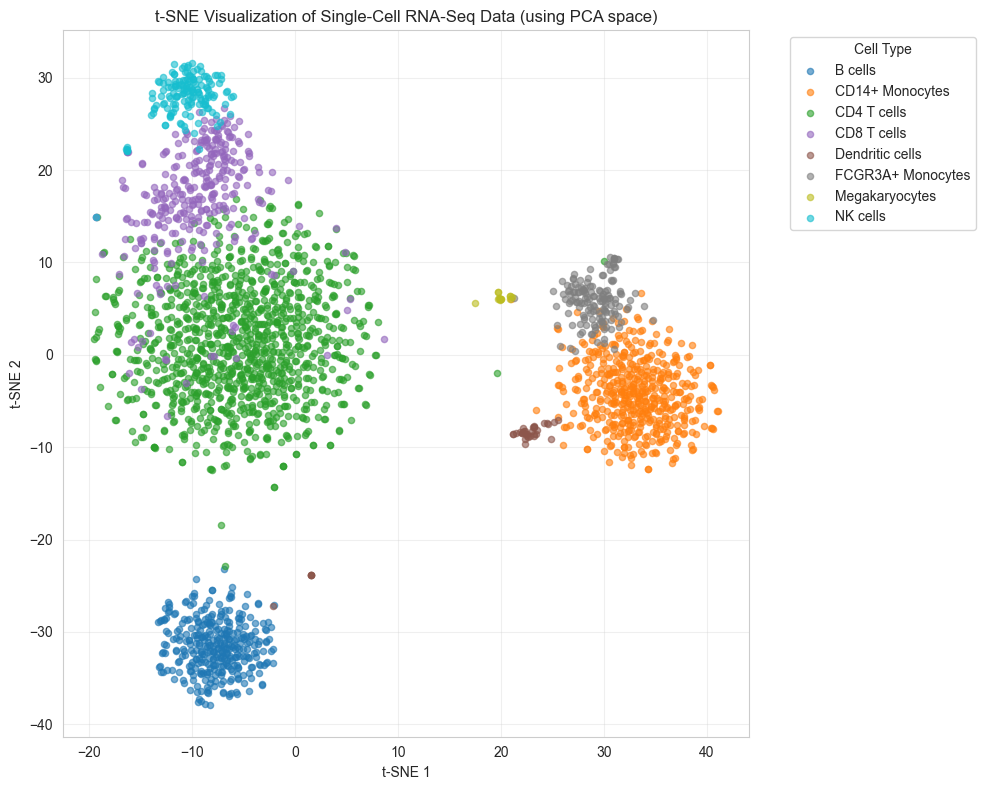

In [183]:
# t-SNE visualization
# Using PCA space (like scanpy) for better results
print("Running t-SNE (this may take a few minutes)...")
print("Note: Using PCA space instead of raw scaled data")
print("      This typically gives better separation of cell types")

# Use PCA space for t-SNE (like scanpy does)
# First ensure we have PCA
if 'X_pca' not in locals():
    print("Computing PCA first...")
    pca = PCA(n_components=50)
    X_pca = pca.fit_transform(X_scaled)

# Use first 50 PCs for t-SNE (similar to scanpy's approach)
n_pcs = min(50, X_pca.shape[1])
X_for_tsne = X_pca[:, :n_pcs]

# t-SNE on PCA space
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_for_tsne)

print(f"t-SNE embedding shape: {X_tsne.shape}")
print(f"Used {n_pcs} principal components for t-SNE")

# Plot t-SNE
plt.figure(figsize=(10, 8))

# Use louvain labels from adata if available
if 'adata' in locals() and 'louvain' in adata.obs.columns:
    cell_labels = adata.obs['louvain'].values
    unique_types = np.unique(cell_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))
    for k, cell_type in enumerate(unique_types):
        mask = cell_labels == cell_type
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   c=[colors[k]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
elif true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for k, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        plt.scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                   c=[colors[k]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=0.6, s=20, c='steelblue')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of Single-Cell RNA-Seq Data (using PCA space)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Dimension Reduction using PCA

Principal Component Analysis (PCA) is a linear dimensionality reduction technique that finds the directions of maximum variance in the data.

### Why PCA?
- **Dimensionality reduction**: Reduce from thousands of genes to a few principal components
- **Noise reduction**: First components capture signal, later components capture noise
- **Visualization**: Can visualize data in 2D/3D using first 2-3 PCs
- **Preprocessing**: Often used before clustering or other analyses

In [184]:
# Apply PCA
print("Applying PCA...")
pca = PCA(n_components=50)  # Keep top 50 components
X_pca = pca.fit_transform(X_scaled)

print(f"PCA transformed data shape: {X_pca.shape}")
print(f"Original data shape: {X_scaled.shape}")
print(f"\nVariance explained by first 10 components:")
for i in range(min(10, len(pca.explained_variance_ratio_))):
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]:.4f} ({pca.explained_variance_ratio_[i]*100:.2f}%)")

Applying PCA...
PCA transformed data shape: (2638, 50)
Original data shape: (2638, 1838)

Variance explained by first 10 components:
  PC1: 0.0179 (1.79%)
  PC2: 0.0143 (1.43%)
  PC3: 0.0104 (1.04%)
  PC4: 0.0074 (0.74%)
  PC5: 0.0031 (0.31%)
  PC6: 0.0028 (0.28%)
  PC7: 0.0026 (0.26%)
  PC8: 0.0023 (0.23%)
  PC9: 0.0021 (0.21%)
  PC10: 0.0020 (0.20%)


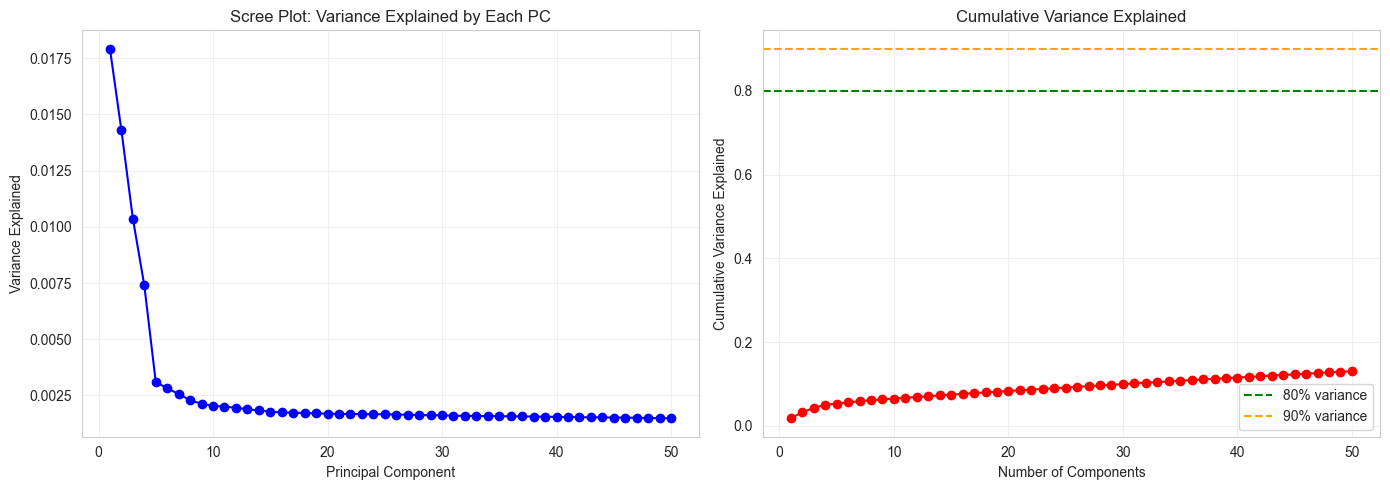


Number of components needed for 80% variance: 1
Number of components needed for 90% variance: 1


In [185]:
# Visualize variance explained
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
n_components_to_plot = min(50, len(pca.explained_variance_ratio_))
axes[0].plot(range(1, n_components_to_plot + 1),
             pca.explained_variance_ratio_[:n_components_to_plot], 'bo-')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Variance Explained')
axes[0].set_title('Scree Plot: Variance Explained by Each PC')
axes[0].grid(True, alpha=0.3)

# Cumulative variance explained
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
axes[1].plot(range(1, n_components_to_plot + 1),
             cumulative_variance[:n_components_to_plot], 'ro-')
axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% variance')
axes[1].axhline(y=0.9, color='orange', linestyle='--', label='90% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Variance Explained')
axes[1].set_title('Cumulative Variance Explained')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find number of components for 80% and 90% variance
n_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"\nNumber of components needed for 80% variance: {n_80}")
print(f"Number of components needed for 90% variance: {n_90}")

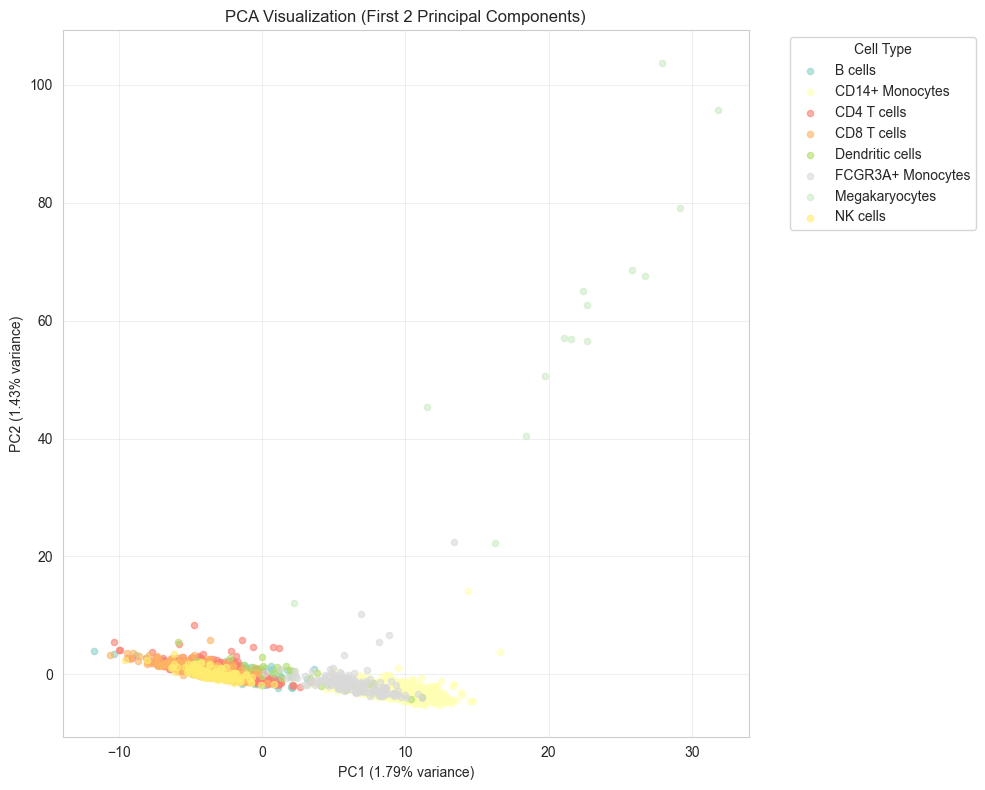

In [186]:
# Visualize PCA in 2D
plt.figure(figsize=(10, 8))
if true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for i, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
                   c=[colors[i]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=20, c='steelblue')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('PCA Visualization (First 2 Principal Components)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. K-Means Clustering to Identify Cell Clusters

K-means clustering is a popular unsupervised learning algorithm that partitions data into k clusters by minimizing within-cluster variance.

### Steps:
1. Choose number of clusters (k)
2. Initialize k centroids randomly
3. Assign each cell to nearest centroid
4. Update centroids to mean of assigned cells
5. Repeat until convergence

In [187]:
# Determine optimal number of clusters using elbow method and silhouette score
from sklearn.metrics import silhouette_score

# Use PCA-reduced data for faster computation
X_for_clustering = X_pca[:, :30]  # Use first 30 PCs

k_range = range(2, 11)
inertias = []
silhouette_scores = []

print("Testing different numbers of clusters...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_for_clustering)
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_for_clustering, labels)
    silhouette_scores.append(sil_score)
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

Testing different numbers of clusters...
  k=2: Inertia=406331.06, Silhouette=0.2661
  k=3: Inertia=344350.31, Silhouette=0.2451
  k=4: Inertia=305939.00, Silhouette=0.2593
  k=5: Inertia=272002.00, Silhouette=0.2750
  k=6: Inertia=262308.75, Silhouette=0.2098
  k=7: Inertia=248728.12, Silhouette=0.2099
  k=8: Inertia=239703.56, Silhouette=0.2101
  k=9: Inertia=238864.94, Silhouette=0.1033
  k=10: Inertia=226787.03, Silhouette=0.1019


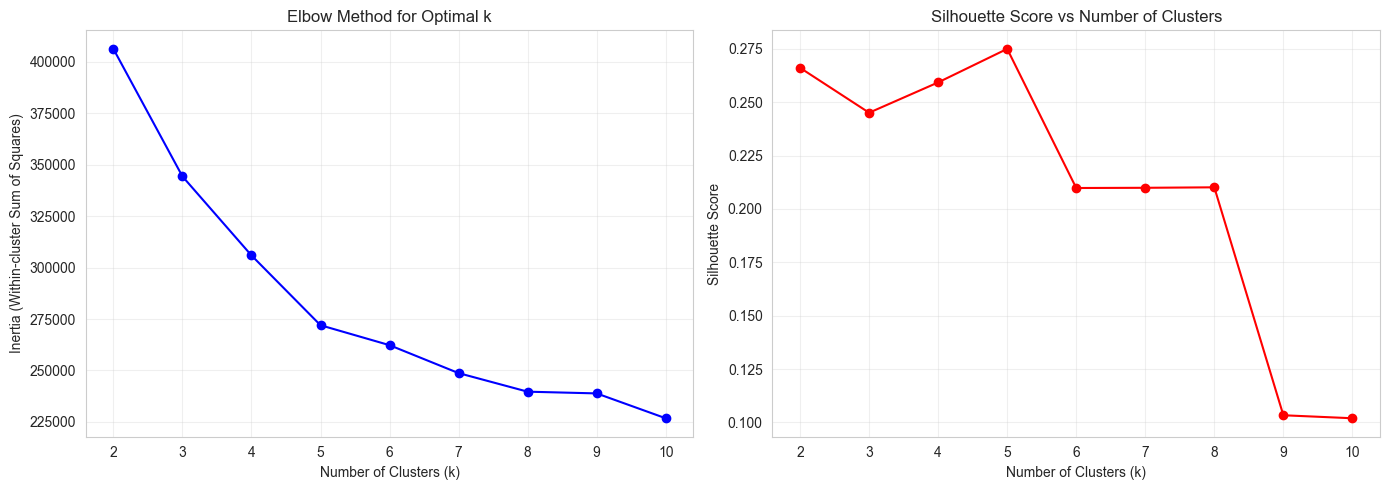


Optimal number of clusters (based on silhouette score): 5


In [188]:
# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Elbow curve
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (Within-cluster Sum of Squares)')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k (highest silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (based on silhouette score): {optimal_k}")

In [189]:
# Apply K-means with optimal k
k = optimal_k if 'optimal_k' in locals() else 4
print(f"Applying K-means clustering with k={k}...")

kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_for_clustering)

print(f"Clustering complete!")
print(f"Cluster sizes: {np.bincount(cluster_labels)}")

# Calculate silhouette score
sil_score = silhouette_score(X_for_clustering, cluster_labels)
print(f"Silhouette score: {sil_score:.4f}")

# If we have true labels, calculate adjusted rand index
if true_cell_types is not None:
    ari = adjusted_rand_score(true_cell_types, cluster_labels)
    print(f"Adjusted Rand Index (vs true labels): {ari:.4f}")

Applying K-means clustering with k=5...
Clustering complete!
Cluster sizes: [ 361  237  642   13 1385]
Silhouette score: 0.2750
Adjusted Rand Index (vs true labels): 0.7331


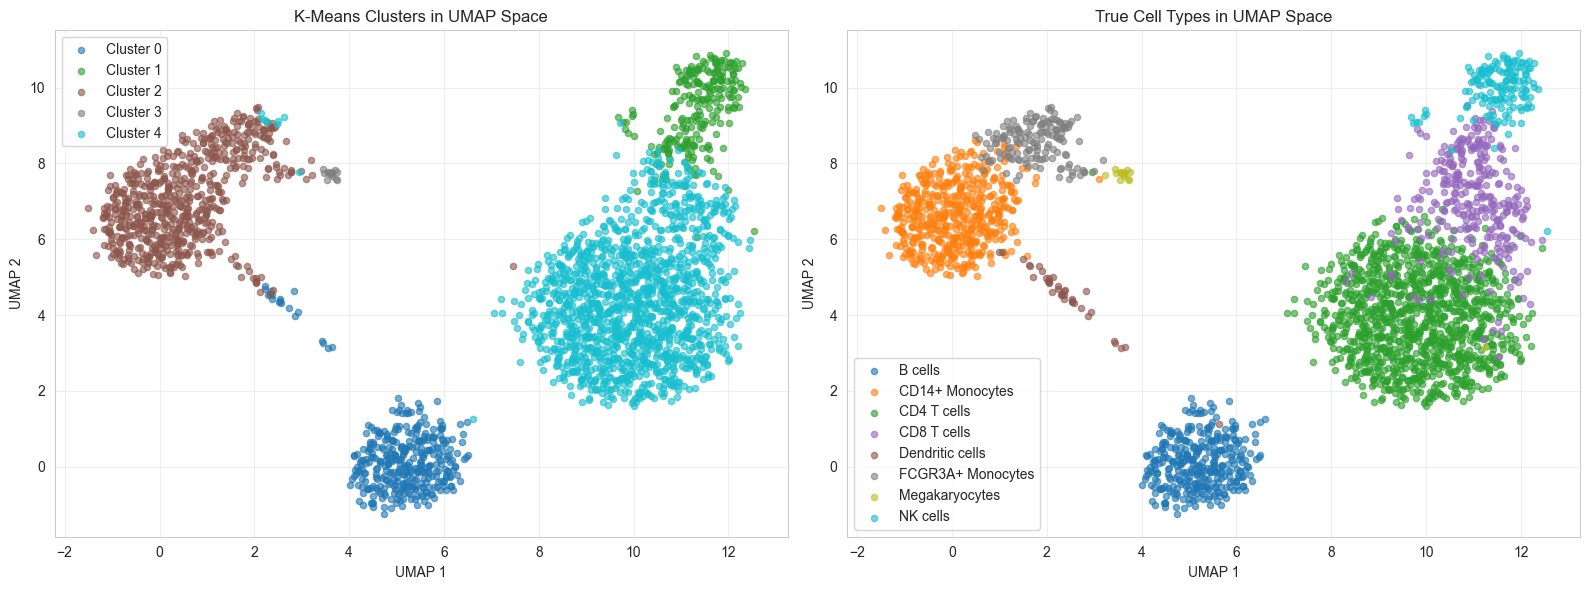

In [190]:
# Visualize clusters in UMAP space
# Note: Requires UMAP to be computed first
if 'X_umap' not in locals():
    print('Error: UMAP not computed yet. Please run the UMAP cell first.')
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # UMAP with cluster labels
    unique_clusters = np.unique(cluster_labels)
    colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
    for j, cluster in enumerate(unique_clusters):
        mask = cluster_labels == cluster
        axes[0].scatter(X_umap[mask, 0], X_umap[mask, 1],
                       c=[colors[j]], label=f'Cluster {cluster}', alpha=0.6, s=20)
    axes[0].set_xlabel('UMAP 1')
    axes[0].set_ylabel('UMAP 2')
    axes[0].set_title('K-Means Clusters in UMAP Space')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # If available, compare with true labels
    if 'adata' in locals() and 'louvain' in adata.obs.columns:
        cell_labels = adata.obs['louvain'].values
        unique_types = np.unique(cell_labels)
        type_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))
        for j, cell_type in enumerate(unique_types):
            mask = cell_labels == cell_type
            axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                          c=[type_colors[j]], label=cell_type, alpha=0.6, s=20)
        axes[1].set_xlabel('UMAP 1')
        axes[1].set_ylabel('UMAP 2')
        axes[1].set_title('True Cell Types in UMAP Space')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

### 4.1 Associate Cell Clusters to Cell Types

After clustering, we can identify which cell types each cluster represents by:
- Finding marker genes (highly expressed genes) for each cluster
- Comparing with known cell type markers
- Using domain knowledge

In [191]:
# Find marker genes for each cluster
# Marker genes are genes that are highly expressed in one cluster compared to others

from scipy import stats

n_markers = 10  # Number of top marker genes per cluster
marker_genes = {}

for cluster_id in unique_clusters:
    # Get cells in this cluster
    cluster_mask = cluster_labels == cluster_id

    # Calculate mean expression in cluster vs others
    cluster_mean = X[cluster_mask].mean(axis=0)
    other_mean = X[~cluster_mask].mean(axis=0)

    # Calculate fold change
    fold_change = cluster_mean - other_mean

    # Get top marker genes
    top_marker_idx = np.argsort(fold_change)[-n_markers:][::-1]
    marker_genes[cluster_id] = {
        'genes': top_marker_idx,
        'fold_change': fold_change[top_marker_idx]
    }

    print(f"\nCluster {cluster_id} top {n_markers} marker genes:")
    for idx, fc in zip(top_marker_idx[:5], fold_change[top_marker_idx][:5]):
        print(f"  Gene {idx}: fold change = {fc:.4f}")


Cluster 0 top 10 marker genes:
  Gene 1720: fold change = 2.5056
  Gene 1010: fold change = 2.2624
  Gene 599: fold change = 2.2292
  Gene 1522: fold change = 2.1300
  Gene 600: fold change = 2.1159

Cluster 1 top 10 marker genes:
  Gene 1208: fold change = 2.9118
  Gene 434: fold change = 2.7705
  Gene 937: fold change = 2.6167
  Gene 1742: fold change = 2.6006
  Gene 1584: fold change = 2.4966

Cluster 2 top 10 marker genes:
  Gene 1583: fold change = 1.9788
  Gene 1700: fold change = 1.9055
  Gene 588: fold change = 1.8908
  Gene 894: fold change = 1.8748
  Gene 590: fold change = 1.8741

Cluster 3 top 10 marker genes:
  Gene 455: fold change = 9.9356
  Gene 456: fold change = 9.7968
  Gene 281: fold change = 9.7632
  Gene 709: fold change = 9.7132
  Gene 548: fold change = 9.4558

Cluster 4 top 10 marker genes:
  Gene 1348: fold change = 1.2119
  Gene 587: fold change = 0.9513
  Gene 103: fold change = 0.8615
  Gene 851: fold change = 0.7127
  Gene 735: fold change = 0.6501


## 5. Advanced Approaches

### 5a. Variational Autoencoder (VAE) for Better Dimension Reduction

VAEs are deep learning models that learn a low-dimensional latent representation of the data. They are particularly powerful for single-cell data because:

- **Non-linear**: Can capture complex, non-linear relationships
- **Probabilistic**: Provides uncertainty estimates
- **Denoising**: Can help remove technical noise
- **Batch correction**: Can integrate data from different batches/experiments

In [192]:
# VAE implementation using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [193]:
# Define VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, latent_dim=32):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Latent space (mean and log variance)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [194]:
# Prepare data for VAE
input_dim = X_scaled.shape[1]
latent_dim = 32  # Dimension of latent space

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X_scaled).to(device)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Initialize model
vae = VAE(input_dim=input_dim, hidden_dim=128, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.001)

print(f"VAE Model:")
print(f"  Input dimension: {input_dim}")
print(f"  Latent dimension: {latent_dim}")
print(f"  Number of parameters: {sum(p.numel() for p in vae.parameters())}")

VAE Model:
  Input dimension: 1838
  Latent dimension: 32
  Number of parameters: 517998


In [195]:
# Training function
def train_vae(model, dataloader, optimizer, epochs=50):
    model.train()
    losses = []

    for epoch in range(epochs):
        epoch_loss = 0
        for batch_idx, (data,) in enumerate(dataloader):
            optimizer.zero_grad()

            # Forward pass
            recon, mu, logvar = model(data)

            # Reconstruction loss (MSE)
            recon_loss = nn.functional.mse_loss(recon, data, reduction='sum')

            # KL divergence loss
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

            # Total loss
            loss = recon_loss + 0.1 * kl_loss  # Weight KL loss

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader.dataset)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return losses

# Train VAE
print("Training VAE...")
vae_losses = train_vae(vae, dataloader, optimizer, epochs=50)

Training VAE...
Epoch [10/50], Loss: 1749.1828
Epoch [20/50], Loss: 1695.9502
Epoch [30/50], Loss: 1650.5856
Epoch [40/50], Loss: 1621.6018
Epoch [50/50], Loss: 1602.4585


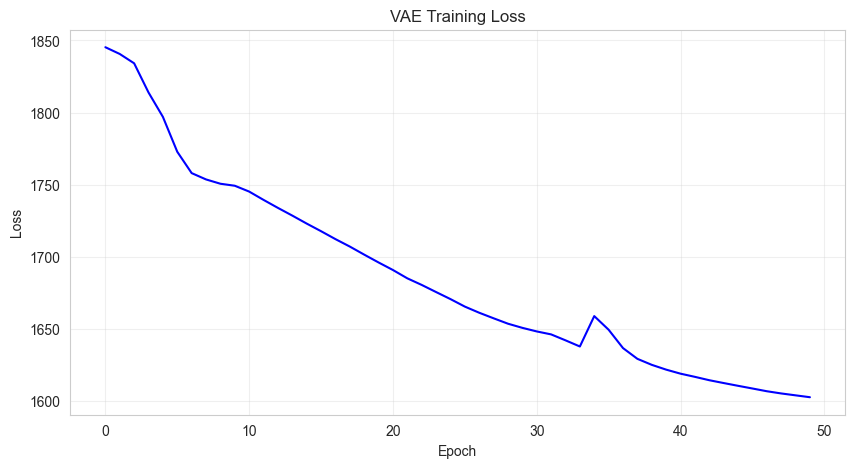

In [196]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(vae_losses, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

In [197]:
# Extract latent representation
vae.eval()
with torch.no_grad():
    mu, _ = vae.encode(X_tensor)
    X_vae = mu.cpu().numpy()

print(f"VAE latent representation shape: {X_vae.shape}")
print(f"Original data shape: {X_scaled.shape}")
print(f"Dimensionality reduction: {X_scaled.shape[1]} -> {X_vae.shape[1]}")

VAE latent representation shape: (2638, 32)
Original data shape: (2638, 1838)
Dimensionality reduction: 1838 -> 32


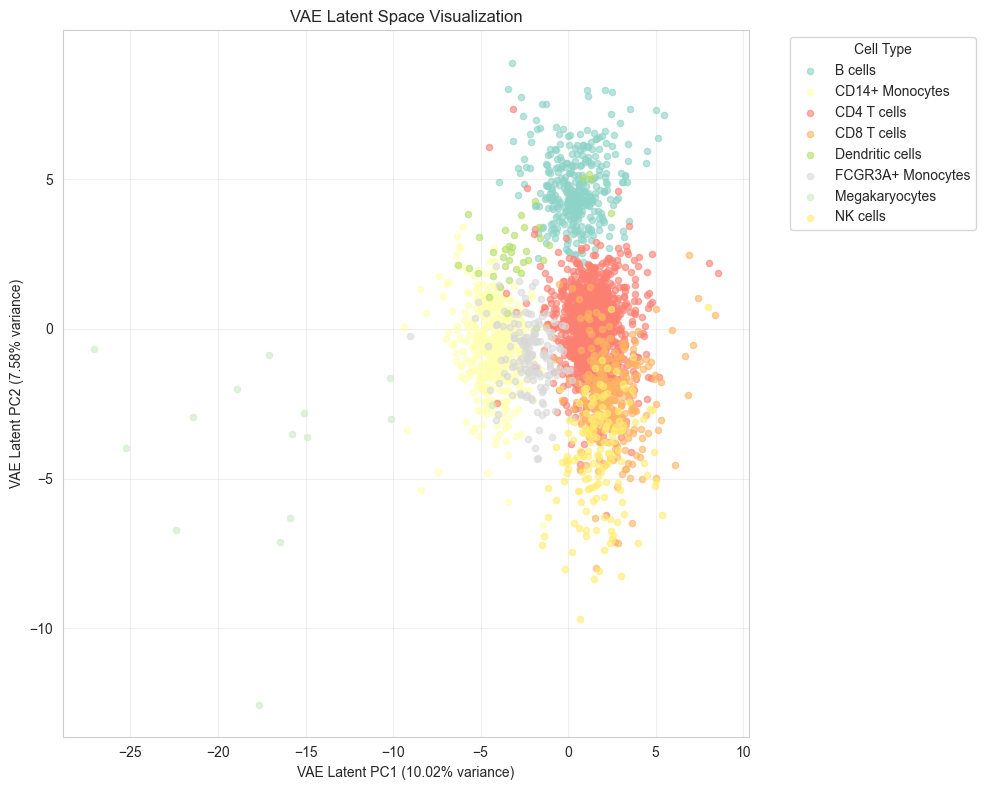

In [198]:
# Visualize VAE latent space using PCA
from sklearn.decomposition import PCA as skPCA

# Project VAE latent space to 2D for visualization
vae_pca = skPCA(n_components=2)
X_vae_2d = vae_pca.fit_transform(X_vae)

plt.figure(figsize=(10, 8))
if true_cell_types is not None:
    unique_types = np.unique(true_cell_types)
    colors = plt.cm.Set3(np.linspace(0, 1, len(unique_types)))
    for i, cell_type in enumerate(unique_types):
        mask = true_cell_types == cell_type
        plt.scatter(X_vae_2d[mask, 0], X_vae_2d[mask, 1],
                   c=[colors[i]], label=cell_type, alpha=0.6, s=20)
    plt.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')
else:
    plt.scatter(X_vae_2d[:, 0], X_vae_2d[:, 1], alpha=0.6, s=20, c='steelblue')
plt.xlabel(f'VAE Latent PC1 ({vae_pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'VAE Latent PC2 ({vae_pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('VAE Latent Space Visualization')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5b. Louvain Graph-Based Clustering Method

Louvain clustering is a community detection algorithm that works on graphs. For single-cell data:

1. **Build a k-nearest neighbor (KNN) graph** from cells
2. **Apply Louvain algorithm** to find communities (clusters)

### Advantages over K-means:
- **No need to specify k**: Automatically determines number of clusters
- **Handles non-convex clusters**: Can find clusters of any shape
- **Works well with graph structure**: Leverages cell-cell similarity
- **Resolution parameter**: Can control cluster granularity

In [199]:
# Build KNN graph for Louvain clustering
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Use PCA-reduced data for faster computation
X_for_graph = X_pca[:, :30]

# Build KNN graph
k = 15  # Number of neighbors
print(f"Building KNN graph with k={k}...")

knn = NearestNeighbors(n_neighbors=k, metric='euclidean')
knn.fit(X_for_graph)
distances, indices = knn.kneighbors(X_for_graph)

# Create adjacency matrix (symmetric)
n_cells = X_for_graph.shape[0]
adjacency = np.zeros((n_cells, n_cells))

for i in range(n_cells):
    for j in range(1, k):  # Skip self (first neighbor)
        neighbor = indices[i, j]
        adjacency[i, neighbor] = 1
        adjacency[neighbor, i] = 1  # Make symmetric

adjacency_sparse = csr_matrix(adjacency)
print(f"KNN graph built: {adjacency_sparse.nnz} edges")

Building KNN graph with k=15...
KNN graph built: 63806 edges


In [200]:
# Apply Louvain clustering

try:

    import igraph as ig

    import leidenalg

    # Convert to igraph format

    print("Converting to igraph format...")

    sources, targets = adjacency_sparse.nonzero()

    edges = list(zip(sources, targets))

    # Create igraph graph

    graph = ig.Graph(edges, directed=False)

    graph.simplify()  # Remove self-loops and multiple edges

    print(f"Graph: {graph.vcount()} vertices, {graph.ecount()} edges")

    # Apply Leiden algorithm (improved version of Louvain)

    print("Applying Leiden clustering (improved Louvain)...")

    partition = leidenalg.find_partition(graph, leidenalg.RBERVertexPartition,
                                        resolution_parameter=0.5, seed=42)

    louvain_labels = np.array(partition.membership)

    print(f"Leiden clustering complete!")

    print(f"Number of clusters: {len(np.unique(louvain_labels))}")

    print(f"Cluster sizes: {np.bincount(louvain_labels)}")

    # Calculate modularity

    modularity = partition.modularity

    print(f"Modularity: {modularity:.4f}")

except ImportError:

    print("igraph or leidenalg not installed. Using alternative: Agglomerative clustering on KNN graph...")

    from sklearn.cluster import AgglomerativeClustering

    # Apply hierarchical clustering

    n_clusters = 4  # Can be determined automatically

    agg_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

    louvain_labels = agg_clustering.fit_predict(X_for_graph)

    print(f"Agglomerative clustering complete!")

    print(f"Number of clusters: {len(np.unique(louvain_labels))}")

    print(f"Cluster sizes: {np.bincount(louvain_labels)}")

Converting to igraph format...
Graph: 2638 vertices, 31903 edges
Applying Leiden clustering (improved Louvain)...
Leiden clustering complete!
Number of clusters: 5
Cluster sizes: [1192  653  420  346   27]
Modularity: 0.6503


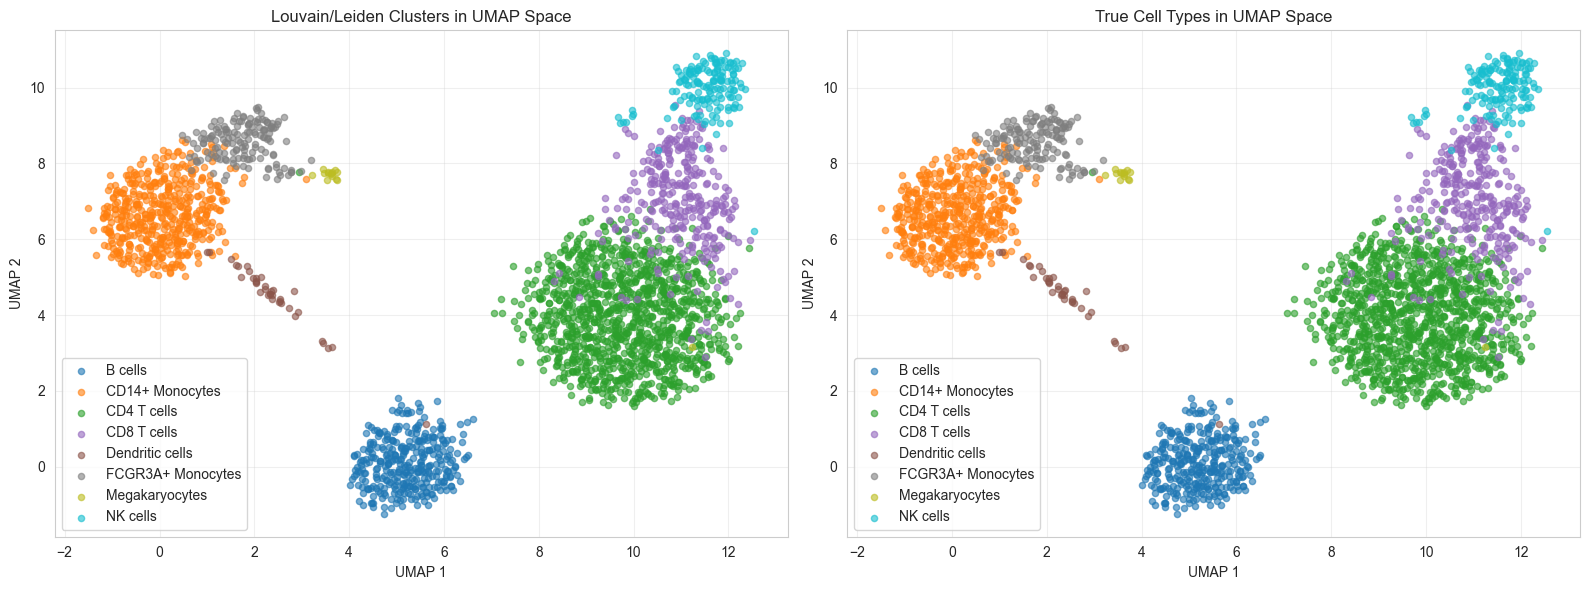

In [201]:
# Visualize Louvain/Leiden clusters in UMAP space
# Note: Requires UMAP to be computed first
if 'X_umap' not in locals():
    print('Error: UMAP not computed yet. Please run the UMAP cell first.')
else:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Get Louvain clusters from adata
    if 'adata' in locals() and 'louvain' in adata.obs.columns:
        louvain_clusters = adata.obs['louvain'].values
        unique_clusters = np.unique(louvain_clusters)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

        for j, cluster in enumerate(unique_clusters):
            mask = louvain_clusters == cluster
            axes[0].scatter(X_umap[mask, 0], X_umap[mask, 1],
                          c=[colors[j]], label=cluster, alpha=0.6, s=20)
        axes[0].set_xlabel('UMAP 1')
        axes[0].set_ylabel('UMAP 2')
        axes[0].set_title('Louvain/Leiden Clusters in UMAP Space')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Compare with true labels (if available)
        if 'true_cell_types' in locals() and true_cell_types is not None:
            unique_types = np.unique(true_cell_types)
            type_colors = plt.cm.tab10(np.linspace(0, 1, len(unique_types)))
            for j, cell_type in enumerate(unique_types):
                mask = true_cell_types == cell_type
                axes[1].scatter(X_umap[mask, 0], X_umap[mask, 1],
                              c=[type_colors[j]], label=cell_type, alpha=0.6, s=20)
            axes[1].set_xlabel('UMAP 1')
            axes[1].set_ylabel('UMAP 2')
            axes[1].set_title('True Cell Types in UMAP Space')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        else:
            axes[1].axis('off')
    else:
        axes[0].text(0.5, 0.5, 'Louvain clusters not found',
                    ha='center', va='center', transform=axes[0].transAxes)
        axes[1].axis('off')

    plt.tight_layout()
    plt.show()

## Summary and Conclusions

In this tutorial, we explored various unsupervised learning techniques for single-cell RNA-seq data:

### Key Takeaways:

1. **Data Visualization**:
   - UMAP and t-SNE provide powerful 2D visualizations of high-dimensional data
   - UMAP is generally faster and preserves both local and global structure

2. **Dimensionality Reduction**:
   - PCA is a linear method that's fast and interpretable
   - VAE provides non-linear dimensionality reduction and can denoise data

3. **Clustering**:
   - K-means is simple and fast but requires specifying k and assumes spherical clusters
   - Louvain/Leiden clustering works on graphs and can find clusters of any shape

4. **Best Practices**:
   - Always preprocess data (log transform, select variable genes, normalize)
   - Use multiple methods and compare results
   - Validate clusters using marker genes and biological knowledge

### Further Reading:
- Scanpy: Python library for single-cell analysis
- Seurat: R package for single-cell genomics
- scVI: Deep generative models for single-cell data